In [100]:
import pandas as pd
import os
import tqdm
import sys
sys.path.append("..")
import aux.models as aux
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [101]:
errored_runs = [
('F', 1, 0.96),
('F', 2, 0.03),
('F', 2, 0.04),
('F', 2, 0.05),
('F', 2, 0.06),
('F', 2, 0.07),
('F', 2, 0.08),
('F', 2, 0.96),
('F', 3, 0.96),
('F', 4, 0.03),
('F', 4, 0.04),
('F', 4, 0.05),
('F', 4, 0.96),
('F', 5, 0.96),
('F', 6, 0.02),
('F', 6, 0.03),
('F', 6, 0.04),
('F', 6, 0.96),
('F', 7, 0.96),
('F', 8, 0.02),
('F', 8, 0.03),
('F', 8, 0.96),
('F', 9, 0.96),
('F', 10, 0.02),
('F', 10, 0.03),
('F', 10, 0.96),
('C', 1, 0.96),
('C', 2, 0.05),
('C', 3, 0.96),
('C', 4, 0.04),
('C', 4, 0.96),
('C', 5, 0.96),
('C', 6, 0.03),
('C', 6, 0.96),
('C', 7, 0.96),
('C', 8, 0.01),
('C', 8, 0.96),
('C', 9, 0.96),
('C', 10, 0.02),
('C', 10, 0.96)
]

In [102]:
def ensure_monotonic(row):
    t = row['sojourn_time']
    c = row['cdf']
    if (t != 0) & (c == 0):
        return 1
    return c

In [103]:
def correct_cdf(series):
    correct_cdf = [series['cdf'][0]]
    for v in series['cdf'][1:]:
        if correct_cdf[-1] == 1:
            correct_cdf.append(1)
        else:
            correct_cdf.append(v)
    return pd.DataFrame({'cdf': correct_cdf, 'sojourn_time': series['sojourn_time']})

In [104]:
def get_method_data(method):
    methodA = [f for f in os.listdir('sweep/method' + method)]
    methodA_data = {}
    for f in tqdm.tqdm_notebook(methodA):
        if f[-4:] == '.csv' and 'runtime' not in f:
            parts = f.split('=')
            rho = float(parts[4][:-4])
            R = int(parts[3][:-4])
            cdf = pd.read_csv('sweep/method' + method + '/' + f, index_col=0)
            cdf['cdf'] = cdf.apply(ensure_monotonic, axis=1)
            runtime = pd.read_csv('sweep/method' + method + '/' + f[:-4] + '-runtime.csv')['runtime'][0]
            methodA_data[(R, rho)] = {'cdf': correct_cdf(cdf), 'runtime': runtime}
    return methodA_data

In [105]:
methodA_data = get_method_data('A')

In [106]:
methodB_data = get_method_data('B')

In [107]:
methodC_data = get_method_data('C')

In [108]:
methodD_data = get_method_data('D')

In [109]:
methodE_data = get_method_data('E')

In [110]:
methodF_data = get_method_data('F')

In [111]:
simulations = [f for f in os.listdir('sweep-expon/') if f != '.DS_Store' if f != 'sweep.py']

In [112]:
timepoints = list(methodA_data[(8, 0.82)]['cdf']['sojourn_time'])
simulation_means = {}
simulation_data = {}
for f in tqdm.tqdm_notebook(simulations):
    parts = f.split('=')
    rho = float(parts[2][:-4])
    R = int(parts[1][:-4])
    recs = []
    data = pd.read_csv('sweep-expon/' + f, index_col=0)
    simulation_data[(R, rho)] = data.set_index('sojourn_time')

In [113]:
methods = {
    'A': methodA_data,
    'B': methodB_data,
    'C': methodC_data,
    'D': methodD_data,
    'E': methodE_data,
    'F': methodF_data,
}

In [114]:
Rs = []
rhos = []
runtimes = {l: [] for l in 'ABCDEF'}
errors = {l: [] for l in 'ABCDEF'}

possible_rhos = [r / 100 for r in range(1, 100)]
for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in possible_rhos:
        Rs.append(R)
        rhos.append(rho)
        for m in 'ABCDEF':
            runtimes[m].append(methods[m][(R, rho)]['runtime'])
            errors[m].append(aux.wasserstein_distance(methods[m][(R, rho)]['cdf']['cdf'], simulation_data[(R, rho)]['cdf'], 0.01))

In [115]:
data = pd.DataFrame({
    'R': Rs,
    'rho': rhos,
    'error A': errors['A'],
    'error B': errors['B'],
    'error C': errors['C'],
    'error D': errors['D'],
    'error E': errors['E'],
    'error F': errors['F'],
    'runtime A': runtimes['A'],
    'runtime B': runtimes['B'],
    'runtime C': runtimes['C'],
    'runtime D': runtimes['D'],
    'runtime E': runtimes['E'],
    'runtime F': runtimes['F']
})

In [116]:
for m, R, rho in errored_runs:
    row_indx = data[(data['R'] == R) & (data['rho'] == rho)].index[0]
    data.loc[row_indx, 'error ' + m] = np.nan

In [18]:
data.to_csv('sweep_summary.csv')

# Store the best method for the percentiles
* 99-percentile
* 99.9-percentile
* 99.99-percentile
* 99.999-percentile
* 99.9999-percentile

In [257]:
def percentile_error(method1, sim, p):
    # Obtains the p-percentile sojourn time error wrt. the simulation
    #
    # method1: the DataFrame of method{A,B,C,D,E,F} for a given (R,rho)
    # sim: the DataFrame of exp-simulation for a given (R,rho)
    # p: the percentile
    #
    # returns: * [0,1] value with 0.3 meaning a 30% error of
    #            the p-percentile sojourn time of method1
    #          * the p-percentile sojourn time diff
    
    # get the method values above (mba) percentiles >=p
    ma = method1[method1['cdf']>=p]
    sa = sim[sim['cdf']>=p]
    
    # In case there is not >=p percentile, get the last value
    mst = ma.iloc[0]['sojourn_time'] if len(ma)>0 else method1.iloc[-1]['sojourn_time']
    sst = sa.index[0] if len(sa)>0 else sim.index[-1]
        
    return (mst - sst) / sst, mst-sst

In [258]:
# Store the best method and sojourn time error
# of the best_percentiles

best_percentiles = {k:{} for k in [.99, .999, .9999, .99999, .999999]}
for p in tqdm.tqdm_notebook( best_percentiles.keys() ):
    for R in range(1,11):
        for rho in np.arange(.01, 1, .01):
            rho_r = round(rho, 2)
            
            best, lowest_err, lowest_abs_err = '?', 100000000000000, 1000000000000000000000
            
            for name, method in [('A', methodA_data), ('B', methodB_data),
                                 ('C', methodC_data), ('D', methodD_data),
                                 ('E', methodE_data), ('F', methodF_data)]:
                
                err, abs_err = percentile_error(method[(R,rho_r)]['cdf'], simulation_data[(R,rho_r)], p)
                if err < lowest_err:
                    best, lowest_err, lowest_abs_err = name, err, abs_err
                    
            best_percentiles[p][(R,rho_r)] = (best, lowest_err, lowest_abs_err)

In [260]:
# Get a table with the error[%] of each
# method for the p-percentile sojourn time

df = []
for p in best_percentiles.keys():
    for R in range(1,11):
        for rho in np.arange(.01, 1, .01):
            rho_r = round(rho, 2)
            method, err, abs_err = best_percentiles[p][R,rho_r]
            df.append([p, R, rho_r, err, abs_err, method])

df = pd.DataFrame(df, columns=['percentile', 'R', 'rho', 'sojourn_err', 'abs_sojourn_err', 'method'])
df.to_csv('best-percentile-method.csv')

# If `best-percentile-method.csv` exists, run below

In the y axis we have $\tfrac{a-s}{s}$, with $a,s$ the approx./simulation percentile for the sojourn time,
respectively.

In [261]:
df = pd.read_csv('best-percentile-method.csv')

In [266]:
print( df['percentile'].unique() )

df[df['percentile']>=.9995]

[0.99     0.999    0.9999   0.99999  0.999999]


Unnamed: 0  percentile   R   rho  sojourn_err  abs_sojourn_err method
1980        1980    0.999900   1  0.01    -0.604055            -5.66      F
1981        1981    0.999900   1  0.02    -0.585912            -5.49      F
1982        1982    0.999900   1  0.03    -0.551381            -4.99      F
1983        1983    0.999900   1  0.04    -0.529282            -4.79      F
1984        1984    0.999900   1  0.05    -0.506077            -4.58      F
...          ...         ...  ..   ...          ...              ...    ...
4945        4945    0.999999  10  0.95    -0.783642           -93.99      A
4946        4946    0.999999  10  0.96    -0.994645          -139.30      F
4947        4947    0.999999  10  0.97    -0.994680          -181.35      C
4948        4948    0.999999  10  0.98    -0.985794          -179.73      C
4949        4949    0.999999  10  0.99    -0.989853          -180.47      F

[2970 rows x 7 columns]

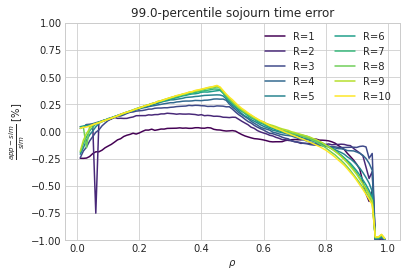

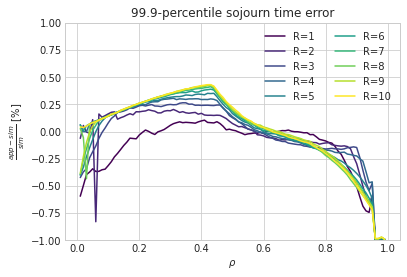

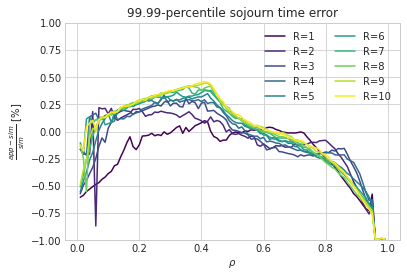

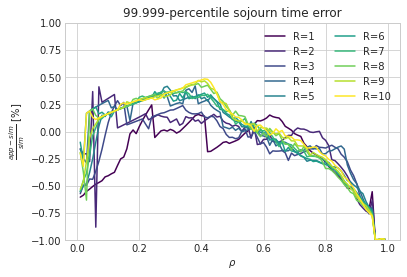

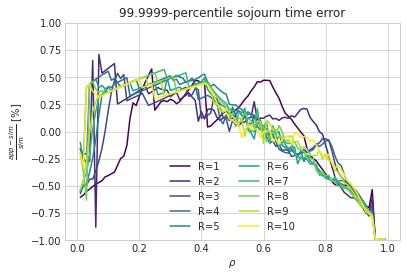

In [263]:
for p in df['percentile'].unique():
    vals = np.linspace(0, 1, 10)
    ax = None
    for R,v in zip(range(1,11), vals):
        col = plt.cm.viridis(v)
        ax = df[(df['percentile']==p) & (df['R']==R)].plot(x='rho', y='sojourn_err',
                                                                ax=ax, label=f'R={R}', color=col)
    plt.ylim(-1,1)
    plt.xlabel(r'$\rho$')
    plt.legend(ncol=2)
    plt.title(f'{p*100}-percentile sojourn time error')
    plt.ylabel(r'$\frac{app-sim}{sim}$ [%]');
    plt.show()

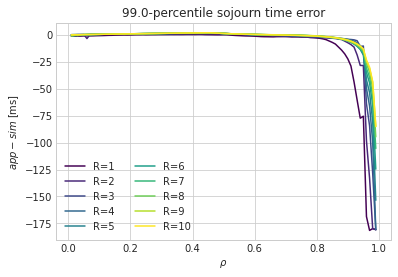

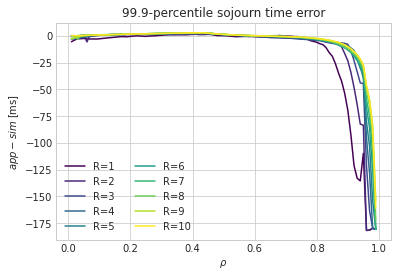

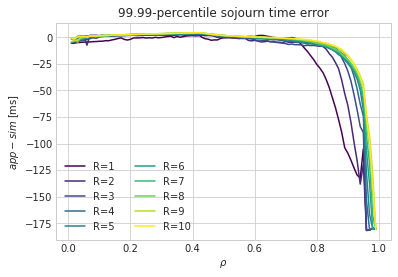

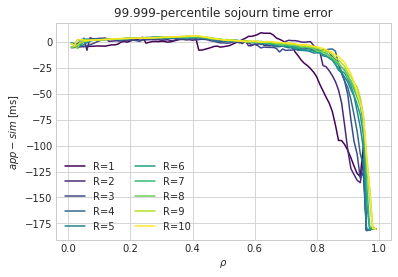

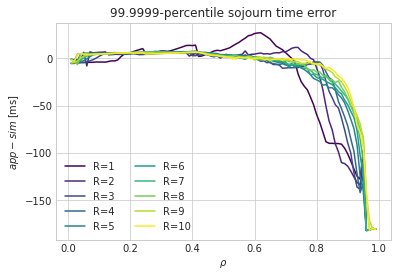

In [265]:
for p in df['percentile'].unique():
    vals = np.linspace(0, 1, 10)
    ax = None
    for R,v in zip(range(1,11), vals):
        col = plt.cm.viridis(v)
        ax = df[(df['percentile']==p) & (df['R']==R)].plot(x='rho', y='abs_sojourn_err',
                                                                ax=ax, label=f'R={R}', color=col)
    #plt.ylim(-1,1)
    plt.xlabel(r'$\rho$')
    plt.legend(ncol=2)
    plt.title(f'{p*100}-percentile sojourn time error')
    plt.ylabel(r'$app-sim$ [ms]');
    plt.show()

# If `sweep_summary.csv` exists and is up to date, just run from here

In [4]:
data = pd.read_csv('sweep_summary.csv')
data

Unnamed: 0   R   rho    error A    error B    error C   error D  \
0             0   1  0.01  82.844046  82.844046   6.794930  0.020989   
1             1   1  0.02  47.704621  47.704621   6.582147  0.021218   
2             2   1  0.03  32.198387  32.198387   6.353401  0.021605   
3             3   1  0.04  23.982097  23.982097   6.126344  0.019866   
4             4   1  0.05  18.998589  18.998589   5.913562  0.026976   
..          ...  ..   ...        ...        ...        ...       ...   
985         985  10  0.95   1.630097   1.666363   0.085187  1.196976   
986         986  10  0.96   2.167821   2.197344        NaN  1.726202   
987         987  10  0.97   3.038928   3.059935   7.062932  2.587482   
988         988  10  0.98   4.908442   4.919326   6.077184  4.446010   
989         989  10  0.99  10.429811  10.429294  11.108159  9.955565   

      error E    error F   runtime A   runtime B    runtime C    runtime D  \
0    0.020989   0.120107  692.831676  692.786004   672.282067  7155.056367   
1    0.021218   0.095583  525.353909  521.425080   499.094383  7271.758162   
2    0.021605   0.087562  437.858717  437.961851   428.258678  7489.081901   
3    0.019866   0.082899  391.479279  394.306478   378.394528  7625.550101   
4    0.026976   0.070090  366.453722  363.489399   350.313872  7591.359248   
..        ...        ...         ...         ...          ...          ...   
985  0.935211   0.870593  296.705255  298.993405   287.208892  6479.687483   
986  1.459475        NaN  309.095417  317.726915   162.094600  6462.258020   
987  2.315547   3.518623  308.655263  300.719828   896.763273  6465.019055   
988  4.168611   5.004211  315.633785  290.359861   835.594669  6467.893616   
989  9.672435  10.873096  315.451513  289.659503  1045.346706  6491.585706   

       runtime E    runtime F  
0    8215.606910  8720.385365  
1    8190.054166  8101.624850  
2    8175.931888  8235.984729  
3    7929.471987  8198.455907  
4    7722.485516  8280.884708  
..           ...          ...  
985  7378.346480  7492.774838  
986  8505.194384  3777.186210  
987  8353.817240  8488.109384  
988  5999.566990  7783.954880  
989  5565.682750  7826.585883  

[990 rows x 15 columns]

# Comparing Methods A, B, C, D, E, F, and Simulation:

In [5]:
def plot_runtime_and_errors(R):
    cmap = matplotlib.cm.get_cmap('viridis')
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, m in enumerate('ABCDEF'):
        ax[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error ' + m], linestyle='solid', c=cmap((i)/5), label=m)
    ax[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
    ax[0].set_ylabel('Wasserstein Distance', fontsize=20)
    ax[0].set_ylim(0, 182.32)
    for i, m in enumerate('ABCDEF'):
        ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime ' + m], linestyle='solid', c=cmap((i)/5), label=m)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.28, 0.85), fontsize=18, ncol=6)
    fig.suptitle(f'R = {R}', fontsize=28, y=1.15)
    plt.tight_layout()
    return fig

# Just looking at each methods in isolation:

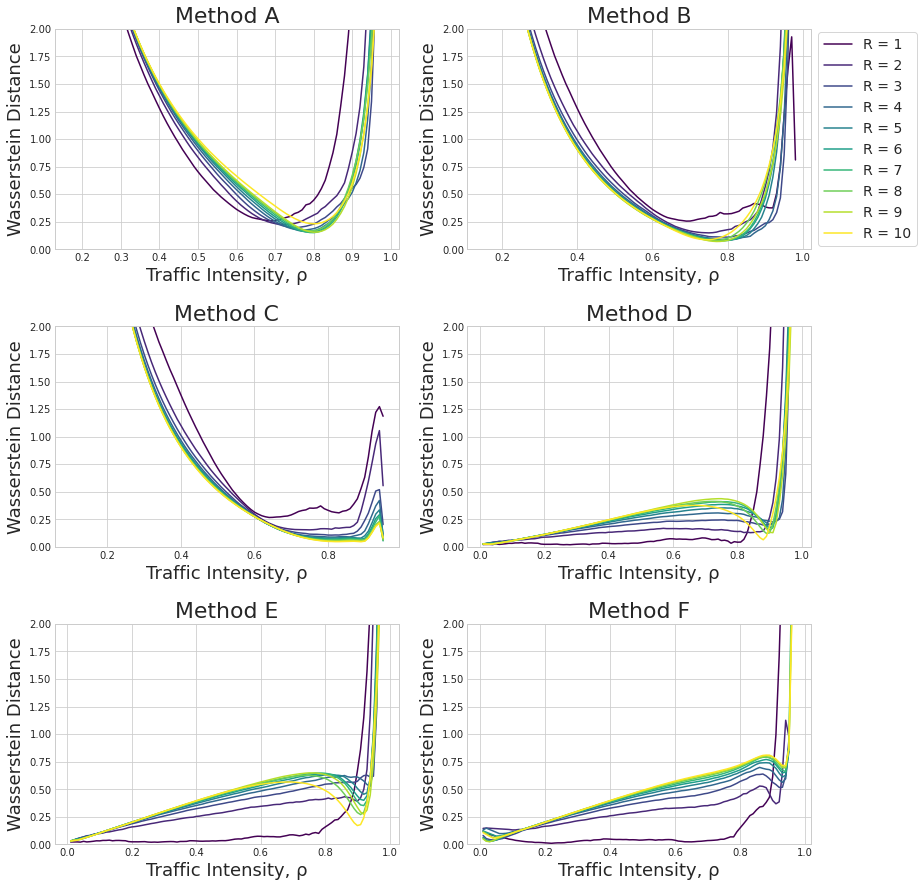

In [6]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 15))
coords = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
vals = np.linspace(0, 1, 10)

for coord, m in zip(coords, 'ABCDEF'):
    for R, v in zip(range(1, 11), vals):
        col = plt.cm.viridis(v)
        data_masked = data[data['error ' + m] < 5]
        axarr[coord].plot(data_masked[data_masked['R'] == R]['rho'], data_masked[data_masked['R'] == R]['error ' + m], c=col, label=f'R = {R}')
    axarr[coord].set_ylim(0, 2)
    axarr[coord].set_xlabel('Traffic Intensity, ρ', fontsize=18)
    axarr[coord].set_ylabel('Wasserstein Distance', fontsize=18)
    axarr[coord].set_title("Method " + m, fontsize=22)

axarr[(0, 0)].legend(fontsize=14, loc='center left', bbox_to_anchor=(2.2, 0.5), ncol=1, frameon=True)
plt.subplots_adjust(left=0.2, hspace=0.35)
plt.savefig('compare_accuracies.pdf')

In [293]:
def compare_accuracies_method(m):
    fig, ax = plt.subplots(1)
    vals = np.linspace(0, 1, 10)
    
    for R, v in zip(range(1, 11), vals):
        col = plt.cm.viridis(v)
        data_masked = data
        ax.plot(data_masked[data_masked['R'] == R]['rho'], data_masked[data_masked['R'] == R]['error ' + m], c=col, label=f'R = {R}')
    ax.set_ylim(0, 2)
    # ax.set_xlabel('Traffic Intensity, ρ', fontsize=22)
    ax.set_xlabel(r'$\rho$', fontsize=20)
    ax.set_ylabel('Wasserstein Distance', fontsize=20)
    ax.set_title("Method " + m, fontsize=20)
    ax.set_xticks([0, .25, .5, .75, 1])
    ax.set_xlim(0,1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=True)
    plt.tight_layout()
    plt.savefig('compare_accuracies_' + m + '.pdf')
    plt.savefig('/tmp/compare_accuracies_' + m + '.pdf')

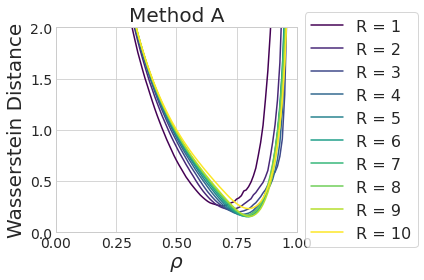

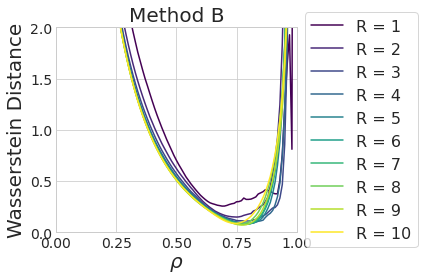

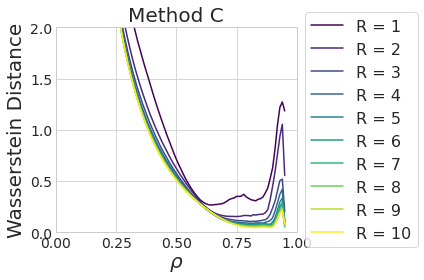

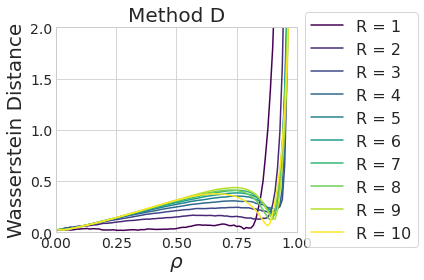

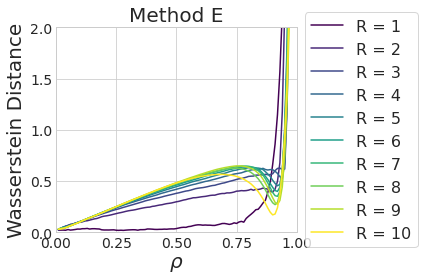

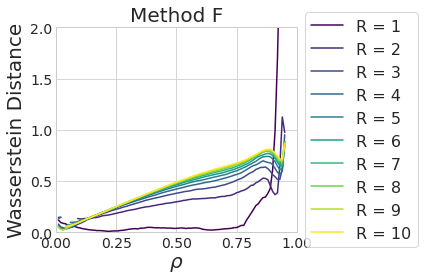

In [294]:
compare_accuracies_method('A');
compare_accuracies_method('B');
compare_accuracies_method('C');
compare_accuracies_method('D');
compare_accuracies_method('E');
compare_accuracies_method('F');

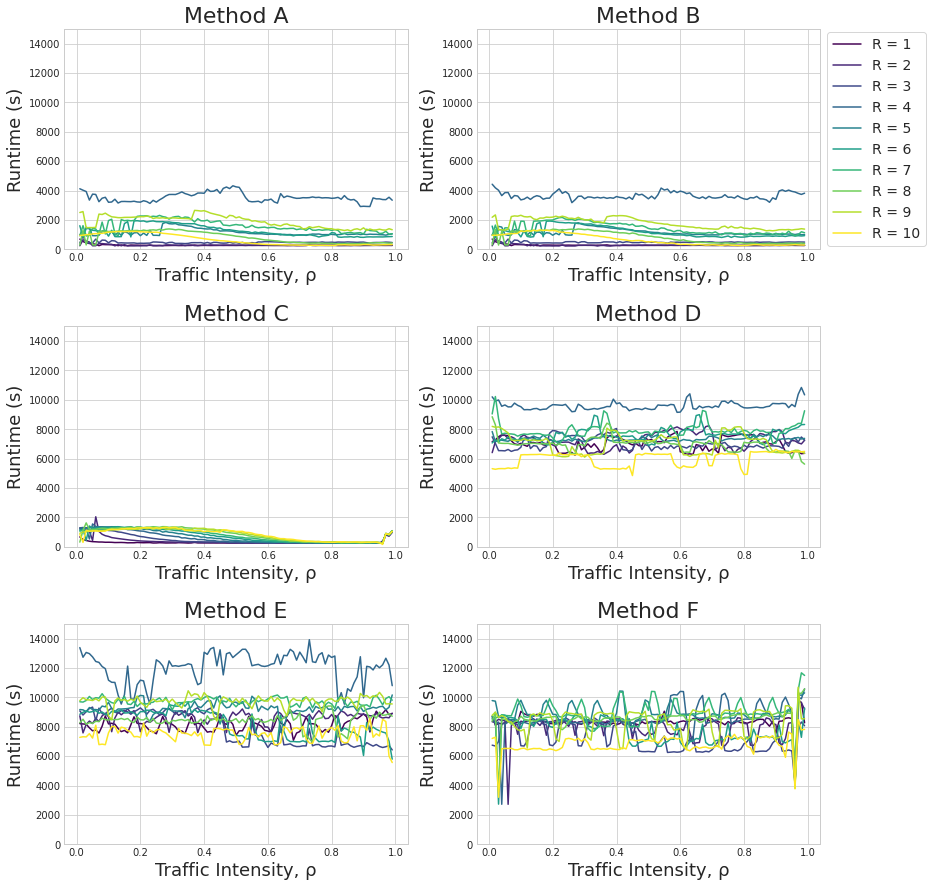

In [9]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 15))
coords = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
vals = np.linspace(0, 1, 10)

for coord, m in zip(coords, 'ABCDEF'):
    for R, v in zip(range(1, 11), vals):
        col = plt.cm.viridis(v)
        axarr[coord].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime ' + m], c=col, label=f'R = {R}')
    axarr[coord].set_ylim(0, 15000)
    axarr[coord].set_xlabel('Traffic Intensity, ρ', fontsize=18)
    axarr[coord].set_ylabel('Runtime (s)', fontsize=18)
    axarr[coord].set_title("Method " + m, fontsize=22)

axarr[(0, 0)].legend(fontsize=14, loc='center left', bbox_to_anchor=(2.2, 0.5), ncol=1, frameon=True)
plt.subplots_adjust(left=0.2, hspace=0.35)
plt.savefig('compare_runtimes.pdf')

In [93]:
def find_best(row):
    A = row['error A']
    B = row['error B']
    C = row['error C']
    D = row['error D']
    E = row['error E']
    F = row['error F']
    if A == min([A, B, C, D, E, F]):
        return 1
    if B == min([A, B, C, D, E, F]):
        return 2
    if C == min([A, B, C, D, E, F]):
        return 3
    if D == min([A, B, C, D, E, F]):
        return 4
    if E == min([A, B, C, D, E, F]):
        return 5
    if F == min([A, B, C, D, E, F]):
        return 6

In [233]:
data['best'] = data.apply(lambda row: find_best(row), axis=1)

In [234]:
data['best'].value_counts()

4    575
3    272
6     54
5     49
2     40
Name: best, dtype: int64

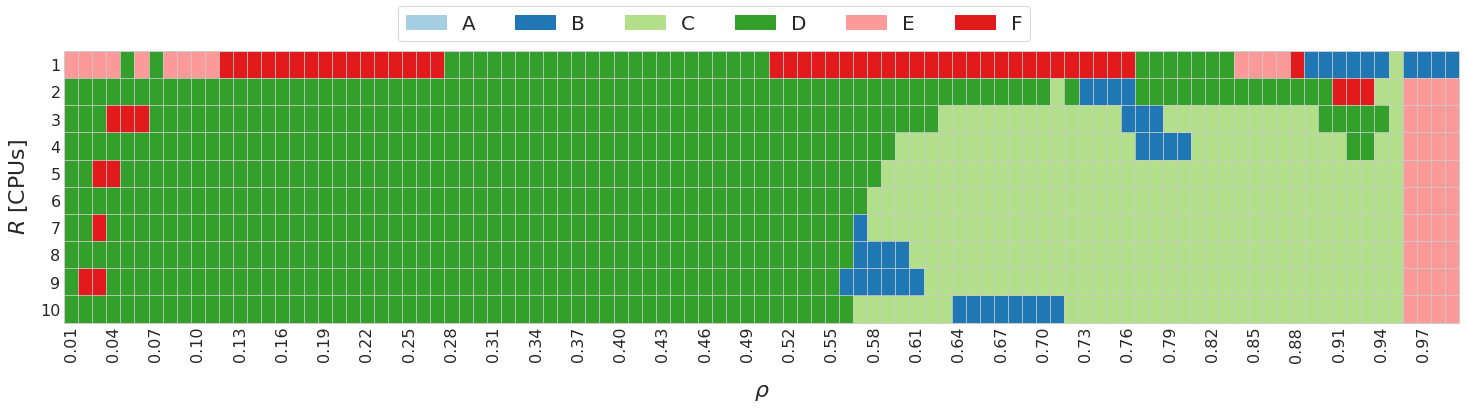

In [252]:
Rs = list(range(1, 11))
rhos = [round(r, 2) for r in np.linspace(0.01, 0.99, 99)]
cols = ['gold', 'firebrick', 'forestgreen', 'royalblue', 'darkorchid', 'darkturquoise']


cols = ['#c51b7d',
'#e9a3c9',
'#fde0ef',
'#e6f5d0',
'#a1d76a',
'#4d9221']

cols=['#feebe2',
'#fcc5c0',
'#fa9fb5',
'#f768a1',
'#c51b8a',
'#7a0177']

cols = ['#a6cee3',
'#1f78b4',
'#b2df8a',
'#33a02c',
'#fb9a99',
'#e31a1c'
]


# Substract value by 1 to match with "cols" list idx
bests_map = [[data[(data['R'] == R) & (data['rho']==rho)]['best'].values[0]-1 for rho in rhos] for R in Rs]


fig, ax = plt.subplots(1, figsize=(25, 5))

# Specify how to normalize colors to map - https://stackoverflow.com/a/52932972
# BEST value to colormap
bests_np = np.array(bests_map, dtype=int)
u, ind = np.unique(bests_np, return_inverse=True)
norm = matplotlib.colors.BoundaryNorm(np.arange(len(u)+1)-.5, len(u))

ax.imshow(bests_np, aspect='auto', cmap=matplotlib.colors.ListedColormap(cols), norm=norm)
ax.set_ylabel(r'$R$ [CPUs]', fontsize=22, labelpad=10)
ax.set_xlabel(r'$\rho$', fontsize=22, rotation=0, labelpad=20)

# y-ticks
ax.set_yticks([R - 0.5 for R in Rs])
ax.set_yticks([R - 1 for R in Rs], minor=True)
ax.set_yticklabels(Rs, minor=True, fontsize=16)
ax.set_yticklabels([])

# x-ticks
ax.set_xticks([r - 0.5 for r in range(len(rhos))])
ax.set_xticks([r for r in range(len(rhos))], minor=True)
ax.set_xticklabels([])
ax.set_xticklabels([str.ljust(str(r), 4, '0') if i%3==0 else '' for i,r in enumerate(rhos)],
                   minor=True, rotation=90, fontsize=16)

for i, m in enumerate('ABCDEF'):
    ax.fill_between([], [], [], color=cols[i], label=m)
ax.legend(fontsize=20, frameon=True, bbox_to_anchor=(0.7, 1.2), ncol=6)
fig.savefig('best_performing.pdf', bbox_inches='tight')
fig.savefig('/tmp/best_performing.pdf', bbox_inches='tight')

In [ ]:
best = data[['R', 'rho', 'best']]

In [98]:
ms = 'ABCDEF'
best['best'] = best['best'].apply(lambda x: ms[x - 1])

/home/netcom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
best.to_csv('best.csv')